<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_vgg16_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Environment Prep

### Package Import

In [0]:
#! pip install keras_metrics
#! pip install imgaug
#! pip install pandas_datareader

In [2]:
import imageio
import imgaug as ia

import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')
#!{sys.executable} -m pip install opencv-python

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
#from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import multiprocessing

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications.resnet import ResNet50
from keras.callbacks import CSVLogger

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
#from tensorflow.keras import get_default_graph

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This code has been tested with TensorFlow 1.6
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(123)

# Transfer learning with VGG16
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input

import random 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
import seaborn as sns

from numpy import loadtxt
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

### Functions

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

## Data Prep

### Data import

In [0]:
%load_ext tensorboard
#import tensorflow as tf
import datetime

In [0]:
!rm -rf ./logs/ 

In [0]:
# typdict = {'NDC':'str'}
# df = pd.read_csv('../Data/directory_of_images.txt',sep='|', dtype=typdict, names=['NDC','IDK','FILE','TYPE','DRUG'])
# df = df.dropna()
# df.DRUG = df.DRUG.str.upper()
# df[['ORIG_FOLDER','IMAGES','FILENAME']] = df.FILE.str.split('/', expand=True)
# df['FILETYPE'] = df.FILENAME.str[-4:]
# df = df[df.FILETYPE != '.WMV']
# df['MANUFACTURER'] = df.NDC.str[:5]

In [5]:
df = pd.read_csv('/content/drive/My Drive/RxID2/Data/rxid15.csv')
df

,Unnamed: 0,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
0,2946,9033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG CAPS,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.JPG,.CR2,90331
1,2947,9033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG CAPS,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.JPG,.CR2,90331
2,2949,9033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,90331
3,2950,9033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,90331
4,2951,9033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,90331
...,...,...,...,...,...,...,...,...,...,...,...
602,127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.JPG,.PNG,681800479
603,127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.JPG,.PNG,681800479
604,127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.JPG,.PNG,681800479
605,127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.JPG,.PNG,681800479


In [0]:
data ='/content/drive/My Drive/RxID2/Data/RxID2_split'
test_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/test'
train_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/train'
val_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/validation'
rw_folder = '/content/drive/My Drive/RxID/RxID15/Realworld images'

---

## model - Acc: 0.65

- dropout
- 100 epochs

In [53]:
%pwd

'/content/drive/My Drive/RxID/Notebooks'

In [7]:
BATCH_SIZE = 32
IMG_SHAPE  = 224 
EPOCHS = 100


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        shuffle=True,
                                                                        target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                        batch_size = BATCH_SIZE) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=(.5,1.5),
                                     shear_range=0.2,
                                     #channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     #fill_mode="nearest",
                                     zoom_range=0.35).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          class_mode='categorical',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

Found 71 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [8]:
from keras.applications import VGG16
cnn_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
cnn_model.trainable = True
# model = models.Sequential()
# model.add(cnn_model)
# model.add(layers.Flatten())

# model.add(layers.Dense(4096, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(15, activation='softmax', kernel_initializer='he_normal'))
# model.summary()

model = models.Sequential(name='model7')

model.add(cnn_model)
model.add(layers.MaxPooling2D((3, 3)))


model.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.SpatialDropout2D(0.1))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
#model.add(layers.ActivityRegularization(l1=0.0)
model.add(layers.Dropout(0.25))

model.add(layers.GaussianNoise(1.0))
model.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))


model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 1024)        4719616   
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 512)         4719104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 512)         0         
_____________________________________________________________

In [10]:
%cd /content/drive/My Drive/RxID2/Notebooks

/content/drive/My Drive/RxID2/Notebooks


In [173]:
csv_logger = CSVLogger('../Models/hist{}.log'.format(model.name), separator=',', append=False)


#checkpoint = ModelCheckpoint("../Models/{}{}.h5".format(model.name,random.randint(1,10000)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    verbose=1,
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count())

Epoch 1/100
10/10 [==============================] - 49s 5s/step - loss: 2.9626 - acc: 0.0600 - val_loss: 2.6411 - val_acc: 0.0800
Epoch 2/100
10/10 [==============================] - 44s 4s/step - loss: 2.7871 - acc: 0.1000 - val_loss: 2.3841 - val_acc: 0.1200
Epoch 3/100
10/10 [==============================] - 43s 4s/step - loss: 2.6424 - acc: 0.1633 - val_loss: 2.0660 - val_acc: 0.2000
Epoch 4/100
10/10 [==============================] - 44s 4s/step - loss: 2.2764 - acc: 0.2533 - val_loss: 1.9372 - val_acc: 0.4133
Epoch 5/100
10/10 [==============================] - 44s 4s/step - loss: 2.1039 - acc: 0.3033 - val_loss: 1.9436 - val_acc: 0.4133
Epoch 6/100
10/10 [==============================] - 44s 4s/step - loss: 1.6294 - acc: 0.4767 - val_loss: 1.2832 - val_acc: 0.6000
Epoch 7/100
10/10 [==============================] - 44s 4s/step - loss: 1.4935 - acc: 0.4967 - val_loss: 0.5280 - val_acc: 0.5867
Epoch 8/100
10/10 [==============================] - 44s 4s/step - loss: 1.3290 - a

In [0]:
model.save('rxv_vgg_4.h5')

---

In [11]:
model = load_model('rxv_vgg_4.h5')
model_val_results = model.evaluate(val_generator)
modelacc = model_val_results[1]
modelacc

3/3 [==============================] - 28s 9s/step


0.8933333158493042

In [0]:
class_size =  int(val_generator.samples / len(val_generator.class_indices))

In [0]:
hist = pd.read_csv('../Models/histmodel7.log', sep=',', engine='python')

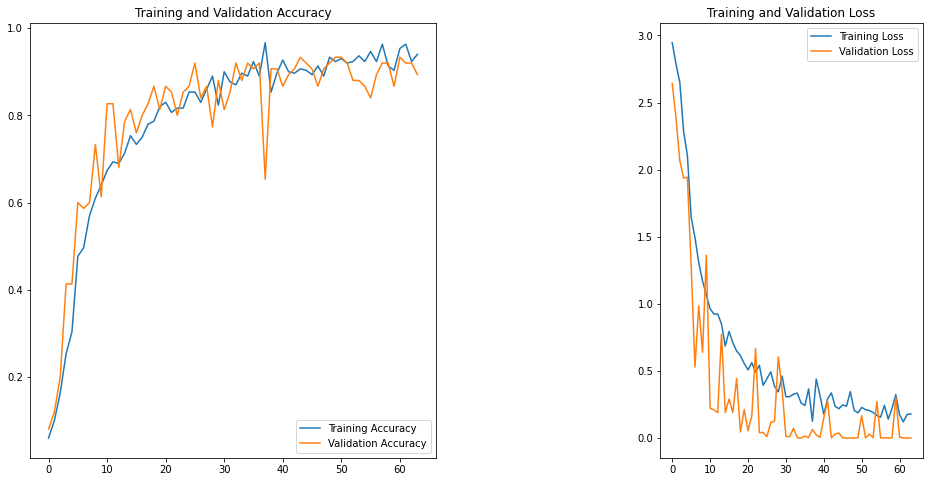

In [14]:
acc = hist['acc']
val_acc = hist['val_acc']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(0,len(hist)), acc, label='Training Accuracy')
plt.plot(range(0,len(hist)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(range(0,len(hist)), loss, label='Training Loss')
plt.plot(range(0,len(hist)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('{}_AccLoss.png'.format(model.name))
plt.show()


[Errno 2] No such file or directory: '../../Notebooks'
/content/drive/My Drive/RxID2/Notebooks


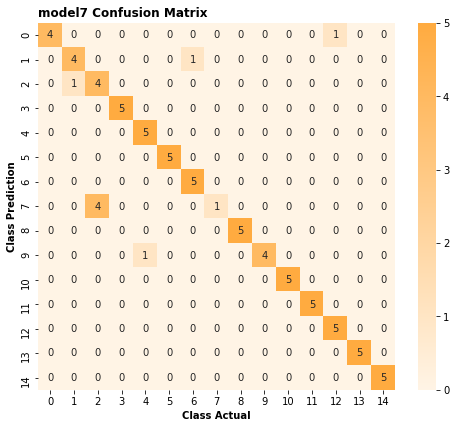

In [15]:
%cd ../../Notebooks
labels = list((val_generator.class_indices).values())
pred = model.predict(val_generator)
y_pred=np.argmax(pred,axis=1)
y_true = val_generator.classes

cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8,6.75))  
pal = sns.light_palette("#ffab40", as_cmap=True)
sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
plt.ylabel('Class Prediction', fontweight='bold')
plt.xlabel('Class Actual', fontweight='bold')
plt.title('{} Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
plt.savefig('../Images/{}_conf'.format(model.name))

In [0]:
print(metrics.classification_report(y_true, y_pred, labels=labs))

In [16]:
%cd ../Data/Download

/content/drive/My Drive/RxID2/Data/Download


In [0]:
dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
samplesdfx = dfx.groupby(['NDC']).min().reset_index()
sampleslist2 = samplesdfx.FILE.tolist()
#len(sampleslist2)

samplefiles = []
for image in sampleslist2:
    smplsplt = image.split('/')
    keep = smplsplt[-1]
    keep = keep[:-4]
    keep= keep +('.JPG')
    samplefiles.append(keep)

    
#for file in os.listdir():
drgimg = os.listdir()
images = []
for file in samplefiles:
    data = plt.imread(file)
    images.append(data)

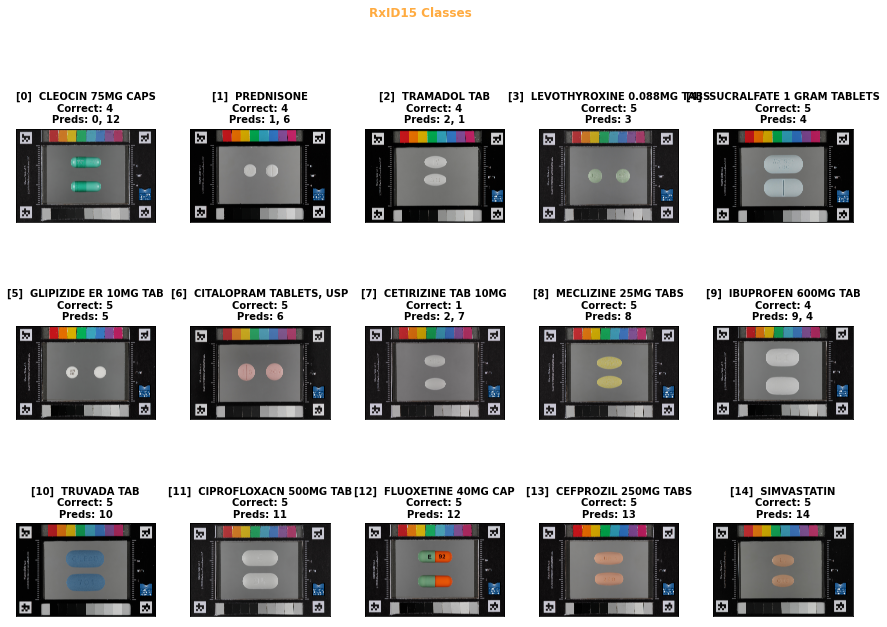

In [18]:
plt.figure(figsize=(15,15))
columns = 5
for i, image in enumerate(images): # iterate through the images in the array 'images'
    k = i * class_size
    j = (i + 1) * class_size
    trues = int(y_true[k:j].mean())
    preds = list(y_pred[k:j]).count(trues)
    #print(trues,preds)
    lst = list(y_pred[k:j])
    preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
    for pred in lst:
        preddict[pred] +=1
    preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
    for k, v in list(preddict.items()):
        if v == 0:
            del preddict[k]
    predlist = list(preddict.keys())
    #predmost = list(set(lst))
    dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
    dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
    title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
    plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
    #plt.margins(tight=True) # not sure which margins this is impacting
    plt.title(title,fontweight='semibold',fontsize='10')
    plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    #plt.savefig('../../Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...

In [20]:
%cd ..

/content/drive/My Drive/RxID2


In [21]:
%cd realworldimgs/

/content/drive/My Drive/RxID2/realworldimgs


In [0]:
import cv2

In [23]:
for pic in os.listdir():
    try:
        img = cv2.imread(pic)
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
        img = np.reshape(img,[1,IMG_SHAPE,IMG_SHAPE,3])
        classes = model.predict_classes(img)
        print(pic, classes)
    except:
        print('shit...')



One - 20200525_095443.jpg [10]
One - 20200525_095455.jpg [4]
One - 20200525_095435.jpg [4]
One - 20200525_095333.jpg [1]
One - 20200525_095337.jpg [10]
One - 20200525_095417.jpg [4]
One - 20200525_095351.jpg [4]
Fourteen_A.jpeg [10]
shit...
Three_A.jpeg [10]
Two_A.jpeg [4]
Eight_A.JPG [3]
Four_A.JPG [10]
Eight_B.JPG [12]
Four_B.JPG [13]
Twelve_A.jpeg [4]
Twelve_B.jpeg [5]
Twelve_C.jpeg [4]
Five_A.jpeg [5]
Nine_A.jpeg [4]
Nine_B.jpeg [4]
Nine_C.jpeg [4]
Ten_A.jpeg [13]
Ten_B.jpeg [13]
Ten_C.jpeg [4]


In [120]:
model.predict_classes(img)

array([4])